In [3]:
%matplotlib inline

import os
import glob
import json
import time
import copy
import pickle
import datetime

import bcolz
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from IPython.display import display

import utils
import config

In [4]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [5]:
def csv_predictions_to_array(path):
    frame = pd.read_csv(path)
    d = {}
    for index, row in frame.iterrows():
        d[row['image']] = np.array(row[classes], dtype=np.float32)
    return np.array([d[k] for k in sorted(d)])


def create_rect_xywh(box, color='red'):
    return plt.Rectangle((box[0], box[1]), box[2], box[3],
                         color=color, fill=False, linewidth=2)

def plot(img):
    x = copy.copy(img)
    x = x + max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    plt.imshow(np.array(x, dtype=np.uint8))

In [6]:
index = 0
info_string = 'boost_v3'
prefix = os.path.join('cache', info_string + '_' + str(index))

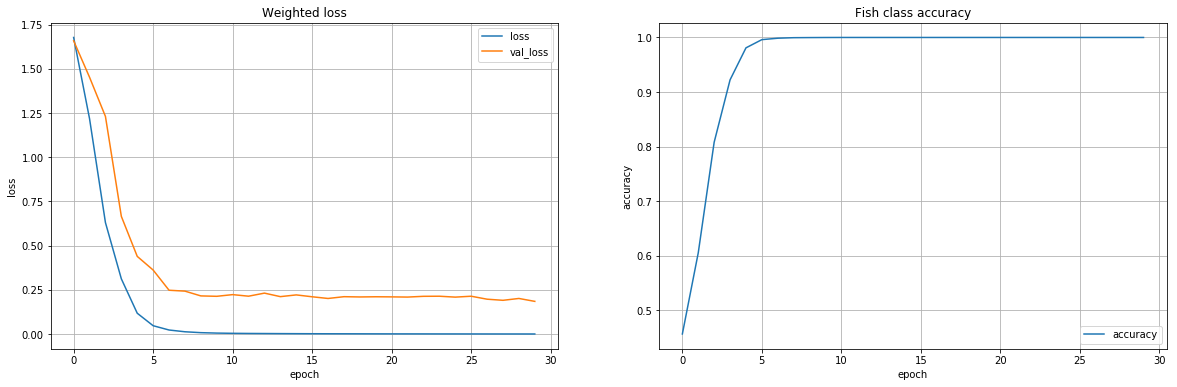

In [8]:
history = pickle.load(open(prefix + '_history.p', 'rb'))

plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.title('Weighted loss')
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(122)
plt.title('Fish class accuracy')
plt.plot(history['acc'], label='accuracy')
# plt.plot(history['val_acc'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.show()

In [9]:
result = 'cache/boost_v3_0_2017-02-21-12-52.csv'
real = csv_predictions_to_array('test_stg1.csv')
pred = csv_predictions_to_array(result)

def do_clip(arr, mx):
    clipped = np.clip(arr, (1-mx)/1, mx)
    return clipped/clipped.sum(axis=1)[:, np.newaxis]

diff = 0
for i in range(len(real)):
    if np.argmax(real[i]) != np.argmax(pred[i]):
        diff += 1

clip_max = 0.98
print('Diff:', diff)
print('Log loss:', log_loss(real, pred))
print('Clipped log loss:', log_loss(real, do_clip(pred, clip_max)))

def clip(x):
    clipped = np.clip(x.values, (1 - clip_max) / 1, clip_max)
    clipped /= clipped.sum()
    return clipped

frame = pd.read_csv(result)
frame[classes] = frame[classes].apply(clip, axis=1)
frame.to_csv('cache/clipped_' + os.path.basename(result), index=False)

Diff: 312
Log loss: 0.98584045624
Clipped log loss: 0.982049350619


In [11]:
test_images = utils.load_array('test_stg1_images.bc')
test_ids = utils.load_array('test_stg1_ids.bc')
test_bboxes = np.array([])
# test_bboxes = utils.load_array('y_test_bbox.bc')

print('test_images:', np.shape(test_images))
print('test_ids:', np.shape(test_ids))
print('test_bboxes:', np.shape(test_bboxes))

test_ids_argsort = np.argsort(test_ids)

def show_pred(i, bb=False):
    plt.figure(figsize=(9, 12))
    plt.imshow(test_images[test_ids_argsort[i]])
    
    ax = plt.gca()
    print('Filename:', test_ids[test_ids_argsort[i]])
    idx = int(i / (config.augmentation_factor + 1))
    p = pred[idx]
    print('Pred: {} ({:.3f})'.format(classes[np.argmax(p)], p[np.argmax(p)]))
    print('Real:', classes[np.argmax(real[idx])])
    if bb:
        box = test_bboxes[test_ids[test_ids_argsort[i]]]
        print('Box (x,y,w,h): ', box)
        if box[2] > 0 and box[3] > 0:
            ax.add_patch(create_rect_xywh(box, 'yellow'))

test_images: (11000, 448, 448, 3)
test_ids: (11000,)
test_bboxes: (0,)


In [12]:
wrong = {}
for i in range(len(classes)):
    wrong[classes[i]] = []
for i in range(len(pred)):
    if np.argmax(pred[i]) != np.argmax(real[i]):
        wrong[classes[np.argmax(real[i])]].append(i)
        
for k, v in wrong.items():
    print(k, v)
    print('***')

YFT [1, 11, 29, 39, 47, 61, 75, 77, 97, 100, 121, 126, 135, 144, 162, 166, 167, 185, 186, 187, 215, 219, 234, 236, 250, 287, 289, 307, 317, 320, 325, 326, 370, 381, 401, 403, 441, 454, 455, 456, 457, 458, 503, 521, 526, 552, 561, 601, 615, 643, 646, 668, 681, 687, 704, 708, 718, 726, 732, 733, 745, 754, 779, 786, 802, 818, 839, 841, 850, 853, 862, 866, 910, 937, 943, 947, 956, 960, 980, 987, 996]
***
SHARK [6, 18, 42, 156, 182, 288, 393, 462, 510, 597, 599, 600, 612, 656, 670, 710, 842, 868, 880, 887, 898, 952, 964, 972, 979, 986, 992]
***
DOL [48, 434, 584, 631, 826]
***
LAG [25, 102, 183, 233, 284, 418, 439, 453, 801, 949]
***
BET [4, 31, 46, 54, 73, 76, 79, 92, 114, 117, 146, 201, 203, 211, 364, 365, 417, 505, 506, 546, 549, 623, 628, 630, 662, 664, 693, 706, 707, 713, 728, 736, 752, 755, 763, 770, 773, 787, 796, 797, 799, 803, 824, 825, 857, 860, 865, 886, 900, 906, 920, 938, 939, 976, 997]
***
NoF [5, 7, 24, 96, 133, 142, 158, 163, 164, 172, 173, 210, 222, 232, 260, 267, 341, 363,

Filename: img_05268.jpg
Pred: ALB (0.599)
Real: SHARK


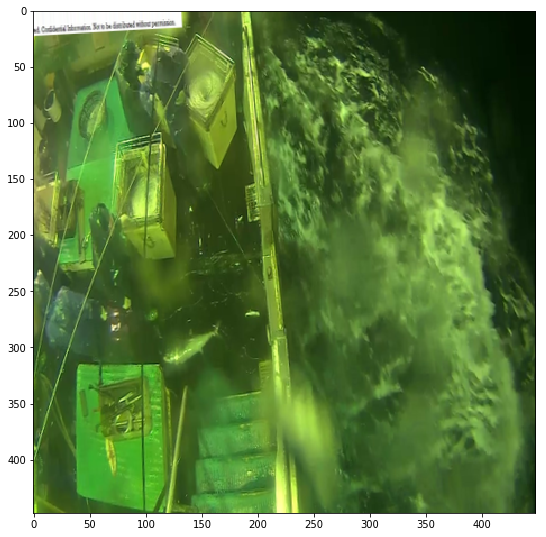

In [13]:
show_pred(656 * (config.augmentation_factor + 1))

In [14]:
from keras.models import model_from_json
f = open(prefix + '.json', 'r')
model = model_from_json(f.read())
f.close()
model.load_weights(prefix + "_weights.h5")
test_feat = utils.load_array('test_stg1_images_feat.bc')

Using TensorFlow backend.


Filename: img_00040.jpg
Pred: ALB (0.848)
Real: SHARK


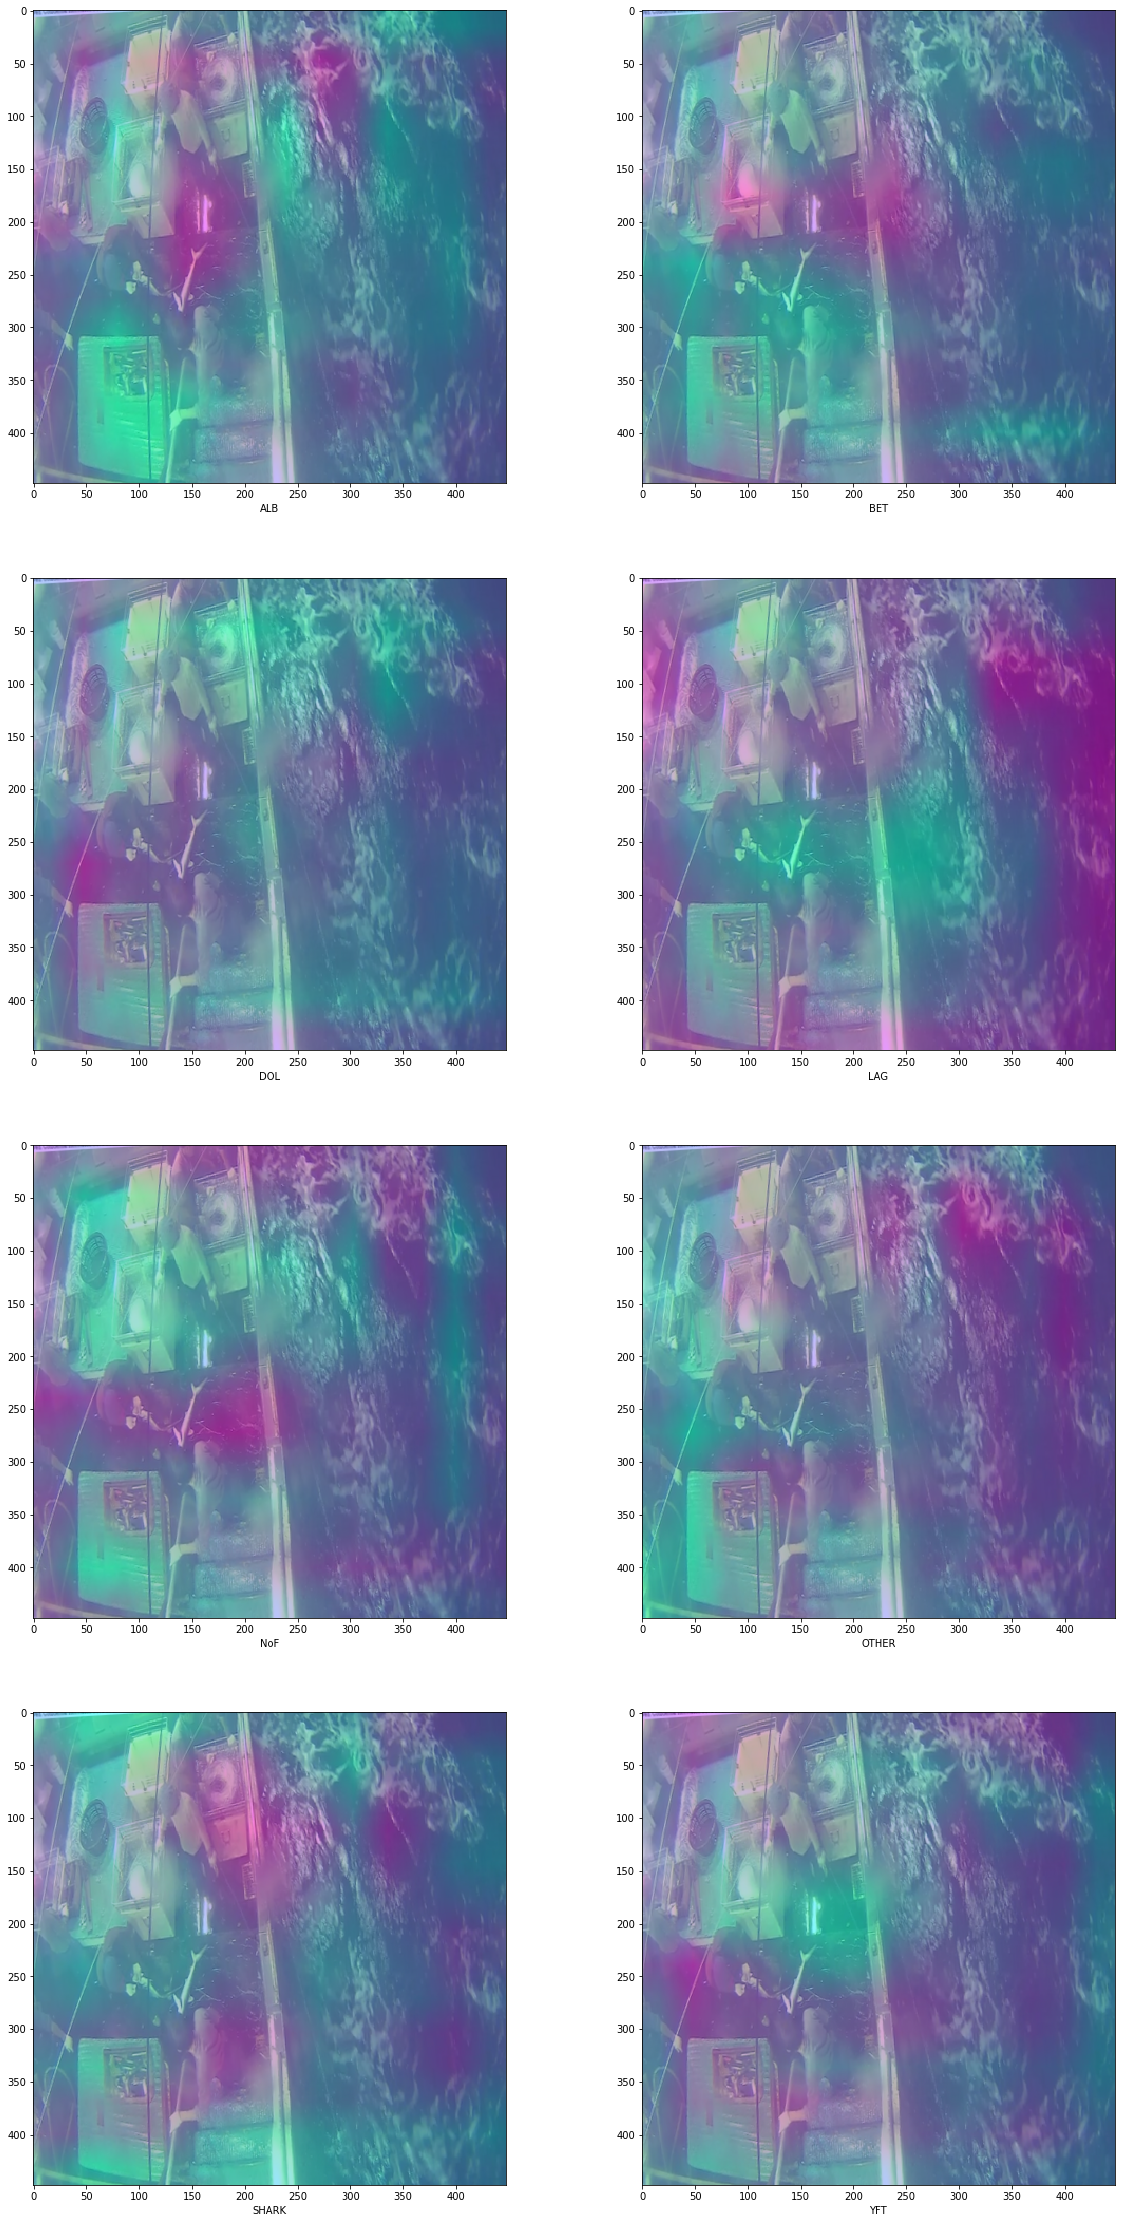

In [15]:
import scipy
import keras.backend as K

input_layer = model.layers[0].input
output_layer = model.layers[-3].output

idx = 6 * (config.augmentation_factor + 1)

print('Filename:', test_ids[test_ids_argsort[idx]])
orig_idx = int(idx / (config.augmentation_factor + 1))
p = pred[orig_idx]
print('Pred: {} ({:.3f})'.format(classes[np.argmax(p)], p[np.argmax(p)]))
print('Real:', classes[np.argmax(real[orig_idx])])
    
output_fn = K.function([input_layer, K.learning_phase()], [output_layer])

plt.figure(figsize=(20, 40))
input_image = np.expand_dims(test_feat[test_ids_argsort[idx]], 0)
output_image = output_fn([input_image, 0])
output_image = np.rollaxis(output_image[0][0], -1)

rows = 4
cols = 2
for r in range(rows):
    for c in range(cols):
        i = r * cols + c
        plt.subplot(rows * 100 + cols * 10 + i + 1)
        x = scipy.misc.imresize(output_image[i], (config.img_h, config.img_w))
        plt.xlabel(classes[i])
        plt.imshow(test_images[test_ids_argsort[idx]])
        plt.imshow(x, cmap="cool", alpha=0.5)

In [16]:
pred_p = {}
real_p = {}
for i in range(len(classes)):
    pred_p[classes[i]] = 0
    real_p[classes[i]] = 0

total = 0
for i in range(len(pred)):
    for j in range(len(classes)):
        pred_p[classes[j]] += pred[i][j]
        real_p[classes[j]] += real[i][j]

for i in range(len(classes)):
    pp = pred_p[classes[i]] / len(pred) * 100.0
    rp = real_p[classes[i]] / len(pred) * 100.0
    print('{}\tpred: {:.2f}%\treal: {:.2f}%\tbias: {:.3f}'.format(classes[i], pp, rp, pp/rp))

ALB	pred: 58.26%	real: 51.50%	bias: 1.131
BET	pred: 4.35%	real: 6.20%	bias: 0.702
DOL	pred: 5.52%	real: 1.60%	bias: 3.451
LAG	pred: 4.10%	real: 3.70%	bias: 1.107
NoF	pred: 9.27%	real: 12.20%	bias: 0.760
OTHER	pred: 7.25%	real: 8.20%	bias: 0.884
SHARK	pred: 1.08%	real: 3.00%	bias: 0.360
YFT	pred: 10.17%	real: 13.60%	bias: 0.748


In [17]:
c_matrix = {}
p_matrix = {
    'TP': {},
    'FP': {},
    'FN': {},
    'TN': {},
    'ACC': {},
    'REC': {},
    'PRE': {},
    'F1': {}
}

for i in range(len(classes)):
    tl = classes[i] + '_T'
    c_matrix[tl] = {}
    for j in range(len(classes)):
        pl = classes[j] + '_P'
        c_matrix[tl][pl] = 0

for i in range(len(classes)):
    cn = classes[i]
    p_matrix['TP'][cn] = 0
    p_matrix['FP'][cn] = 0
    p_matrix['FN'][cn] = 0
    p_matrix['TN'][cn] = 0
    p_matrix['ACC'][cn] = 0
    p_matrix['REC'][cn] = 0
    p_matrix['PRE'][cn] = 0
    p_matrix['F1'][cn] = 0
        
for i in range(len(pred)):
    predicted = classes[np.argmax(pred[i])]
    truelabel = classes[np.argmax(real[i])]
    c_matrix[truelabel + '_T'][predicted + '_P'] += 1
    
    if predicted == truelabel:
        p_matrix['TP'][predicted] += 1
    else:
        p_matrix['FP'][predicted] += 1
        p_matrix['FN'][truelabel] += 1

for i in range(len(classes)):
    cn = classes[i]
    tp = int(p_matrix['TP'][cn])
    fn = int(p_matrix['FN'][cn])
    fp = int(p_matrix['FP'][cn])
    tn = p_matrix['TN'][cn] = len(pred) - (tp + fn + fp)
    p_matrix['ACC'][cn] = (tp + tn) / (tp + tn + fp + fn)
    r = p_matrix['REC'][cn] = tp / (tp + fn)
    p = p_matrix['PRE'][cn] = tp / (tp + fp)
    p_matrix['F1'][cn] = 2 * (p * r) / (p + r)

#pd.options.display.float_format = '{:,.2f}'.format
display(pd.DataFrame(c_matrix))
display(pd.DataFrame(p_matrix)[['TP', 'FP', 'TN', 'FN', 'PRE', 'REC', 'F1', 'ACC']])

,ALB_T,BET_T,DOL_T,LAG_T,NoF_T,OTHER_T,SHARK_T,YFT_T
ALB_P,483,45,4,10,35,46,18,63
BET_P,3,7,0,0,2,1,4,2
DOL_P,4,2,11,0,0,1,0,7
LAG_P,6,2,0,27,0,6,0,0
NoF_P,2,0,0,0,77,0,3,0
OTHER_P,7,1,0,0,4,25,0,9
SHARK_P,0,0,0,0,0,0,3,0
YFT_P,10,5,1,0,4,3,2,55


,TP,FP,TN,FN,PRE,REC,F1,ACC
ALB,483,221,264,32,0.686080,0.937864,0.792453,0.747
BET,7,12,926,55,0.368421,0.112903,0.172840,0.933
DOL,11,14,970,5,0.440000,0.687500,0.536585,0.981
LAG,27,14,949,10,0.658537,0.729730,0.692308,0.976
NoF,77,5,873,45,0.939024,0.631148,0.754902,0.950
OTHER,25,21,897,57,0.543478,0.304878,0.390625,0.922
SHARK,3,0,970,27,1.000000,0.100000,0.181818,0.973
YFT,55,25,839,81,0.687500,0.404412,0.509259,0.894
